# Procesamiento de imágenes · Tarea 5

Cuando una imagen no se toma adecuadamente, lo ideal sería volver a tomarla. Sin embargo, resulta complicado lograr esto si el evento ya ocurrió hace un tiempo. En casos como este resulta útil mejorar la imagen con la ayuda del procesamiento de imágenes.

Tenemos una radiografía que tiene _motion blur_ porque la mochila se estaba moviendo mientras la fotografía fue tomada. Podemos estimar la función de degradación para intentar recuperar información de la imagen original.

### Importante
* Lee atentamente las instrucciones y todo el código.
* Ejecuta las celdas en orden.
* Escribe tu código en las celdas que lo soliciten.
* Usa los nombres de variables que te pidan.
* Confirma que tu código esté correcto corriendo las celdas que dicen "Chequeo".
* Si el chequeo alerta que hay alguna variable incorrecta, vuelve atrás y arréglala. No hay penalización por esto.


### Imagen degradada
<img src="xray_motion.png" alt="drawing" width="600"/>

### Imagen restaurada
<img src="xray_restored.png" alt="drawing" width="600"/>

Esta tarea será distinta a las anteriores. Serás libre de cumplir el objetivo a tu mandera. Puedes usar la librería y el código que desees.

[Aquí](https://scikit-image.org/docs/stable/auto_examples/filters/plot_restoration.html) y [aquí](https://docs.opencv.org/4.5.2/d1/dfd/tutorial_motion_deblur_filter.html) hay unos links que podrían servirte.

##### Importamos las librerías para el chequeo

In [2]:
#import checker
import importlib

## Primer problema

Nuestro fotógrafo, Alex, es fanático de los autos y quisiera saber la patente de este para conocer en detalle el modelo del auto. Lamentablemente, movió la cámara al sacar la foto y la patente quedó ilegible.

<img src="car_motion.png" alt="drawing" width="400"/>

Restaura la imagen para ayudar a Alex a recuperar la patente del auto. La imagen borrosa está almacenada en ```car_motion.png```. Escribe la patente que descubras (sin guiones ni espacios) en ```plate_1``` y la imagen resultante (como un ```numpy.ndarray```) en ```img_restored_1```. ¡Suerte!

Tip: si cargas la imagen con ```cv2.imread```, recuerda que los pixeles retornados son ```np.uint8``` y están entre 0 y 255. Algunas funciones de restauración reciben _floats_ entre 0 y 1 por lo que podrías necesitar modificar la imagen.

**Tip:** analiza las esquinas de la imagen para descubrir qué degradación fue aplicada.

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import skimage.restoration as restoration

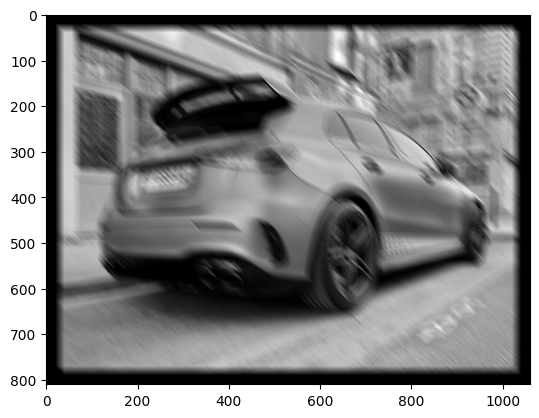

In [4]:
# Escribe tu código en las siguientes líneas
# Tip: la degradación de la primera imagen es diagonal de 20 pixeles.

# Importamos la imagen en blanco y negro
img_1 = cv2.imread('car_motion.png', cv2.IMREAD_GRAYSCALE)
plt.imshow(img_1, cmap='gray')

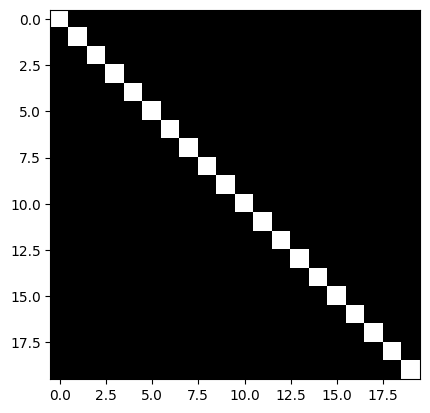

In [5]:
# Creamos la degradación diagonal de 20 pixeles
len_diag_kernel = 20
diag_kernel = np.eye(len_diag_kernel) / len_diag_kernel
plt.imshow(diag_kernel, cmap='gray')

In [6]:
diag_kernel.shape

(20, 20)

In [7]:
# Utilizamos deconvolución de Wiener
img_restored_1, _ = restoration.unsupervised_wiener(img_1 / 255, diag_kernel)

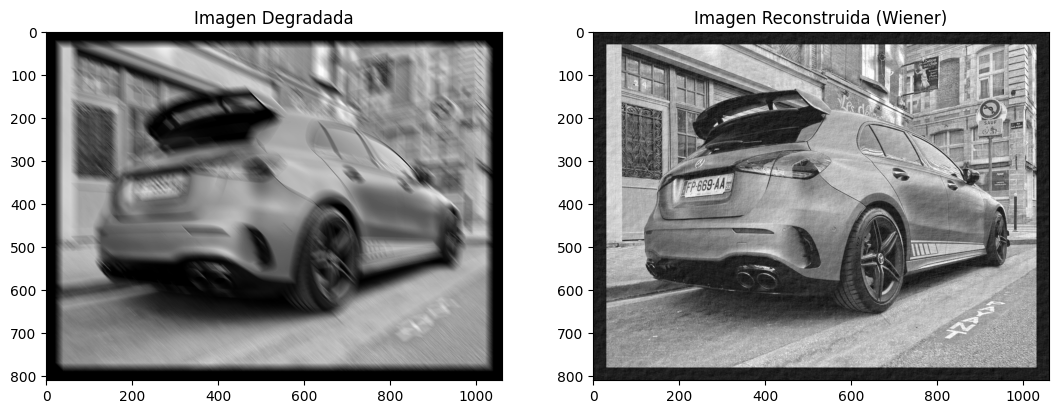

In [8]:
plt.figure(figsize=(20,20))

plt.subplot(131)
plt.title('Imagen Degradada')
plt.imshow(img_1, cmap='gray')
plt.subplot(132)
plt.title('Imagen Reconstruida (Wiener)')
plt.imshow(img_restored_1, cmap='gray')

Tenemos la imagen restaurada, la cual tiene más nitidez. Definimos la patente en una variable.

In [9]:
plate_1 = 'FP669AA'

##### Chequeo

importlib.reload(checker)

assert checker.check_license_plate_1(plate_1)
assert checker.check_img_1(img_restored_1)

## Segundo problema

Alex aún no aprende a sacar fotos. Ahora no movió la cámara pero olvidó enfocar, por lo que nuevamente no podemos leer la patente.

<img src="car_gaussian.png" alt="drawing" width="400"/>

Restaura la imagen para ayudar a Alex a recuperar la patente del auto. La imagen borrosa está almacenada en ```car_gaussian.npy```. Escribe la patente que descubras (sin guiones ni espacios) en ```plate_2``` y la imagen resultante (como un ```numpy.ndarray```) en ```img_restored_2```. ¡Suerte!

**¡Importante!** La imagen está almacenada en un 2ivo ```.npy```, por lo que deberás usar una función distinta a ```cv2.imread```para cargarla.


**Tip:** si le aplicáramos la misma degradación a un punto, se vería como la siguiente imagen.
<img src="psf.png" alt="drawing" width="400"/>

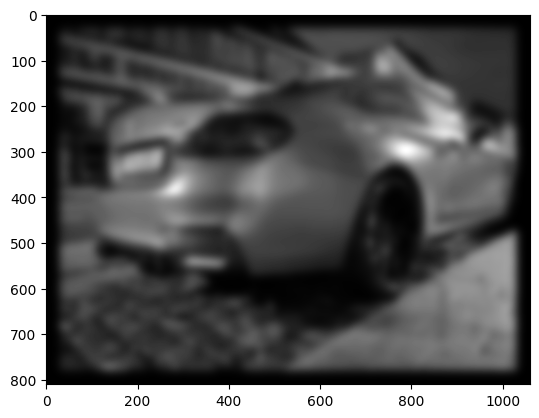

In [253]:
img_2_npy = np.load('car_gaussian.npy')
img_2 = cv2.cvtColor(np.asarray(img_2_npy), cv2.COLOR_BGR2GRAY)
plt.imshow(img_2, cmap='gray')

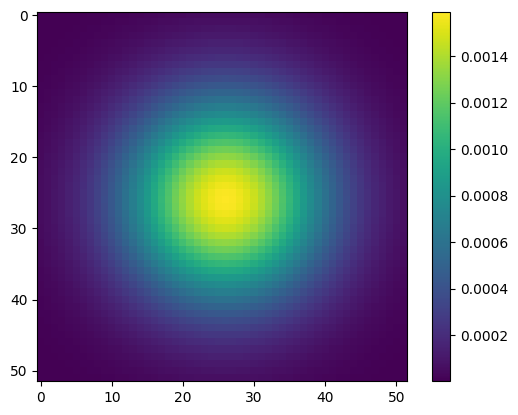

In [259]:
sigma = 10
size_y, size_x = 52, 52
img_2_center_y = size_y // 2
img_2_center_x = size_x // 2

grid_x, grid_y = np.meshgrid(np.arange(size_x), np.arange(size_y))
gaussian_kernel = np.exp(-((grid_x - img_2_center_x)**2 + (grid_y - img_2_center_y)**2)/(2*sigma**2)) / (2 * np.pi * sigma ** 2)

plt.imshow(gaussian_kernel)
plt.colorbar()

Usaremos la formulación vista en clase: $$W(u,v)=\frac{H^*(u, v)}{|H(u,v)|^2 + R}$$ y probaremos distintos valores de R 

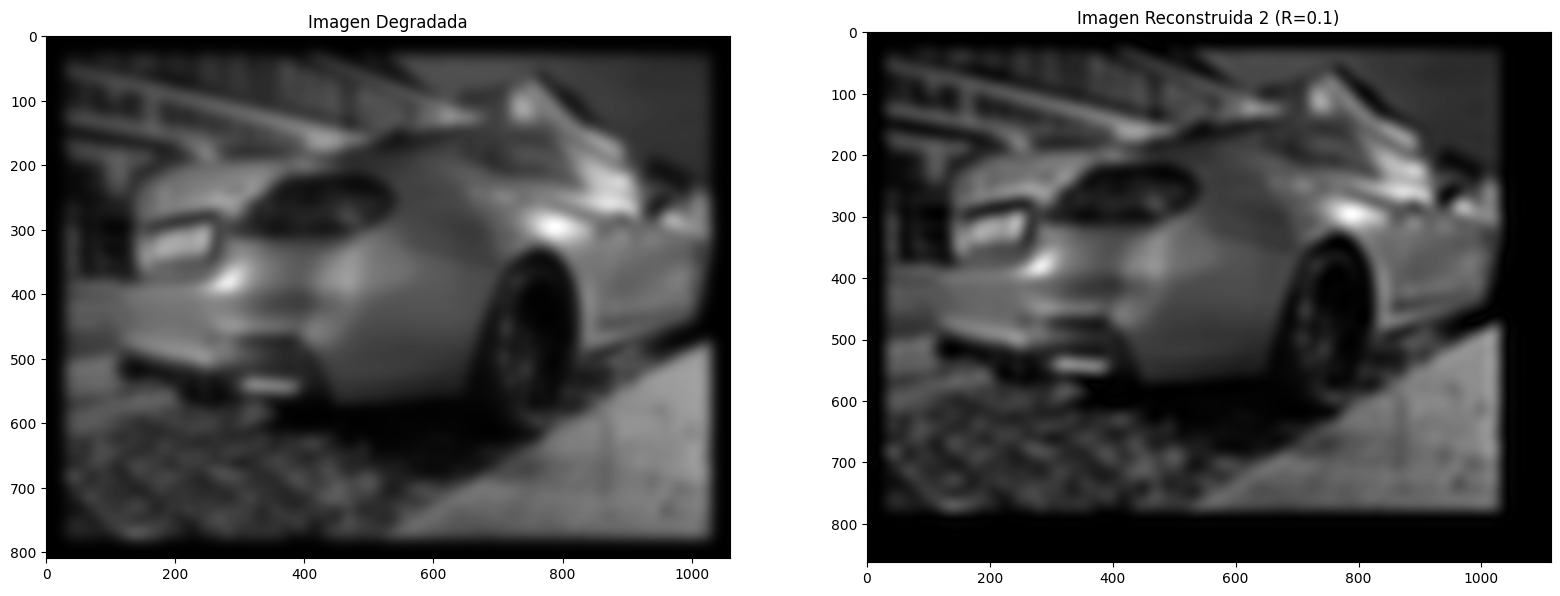

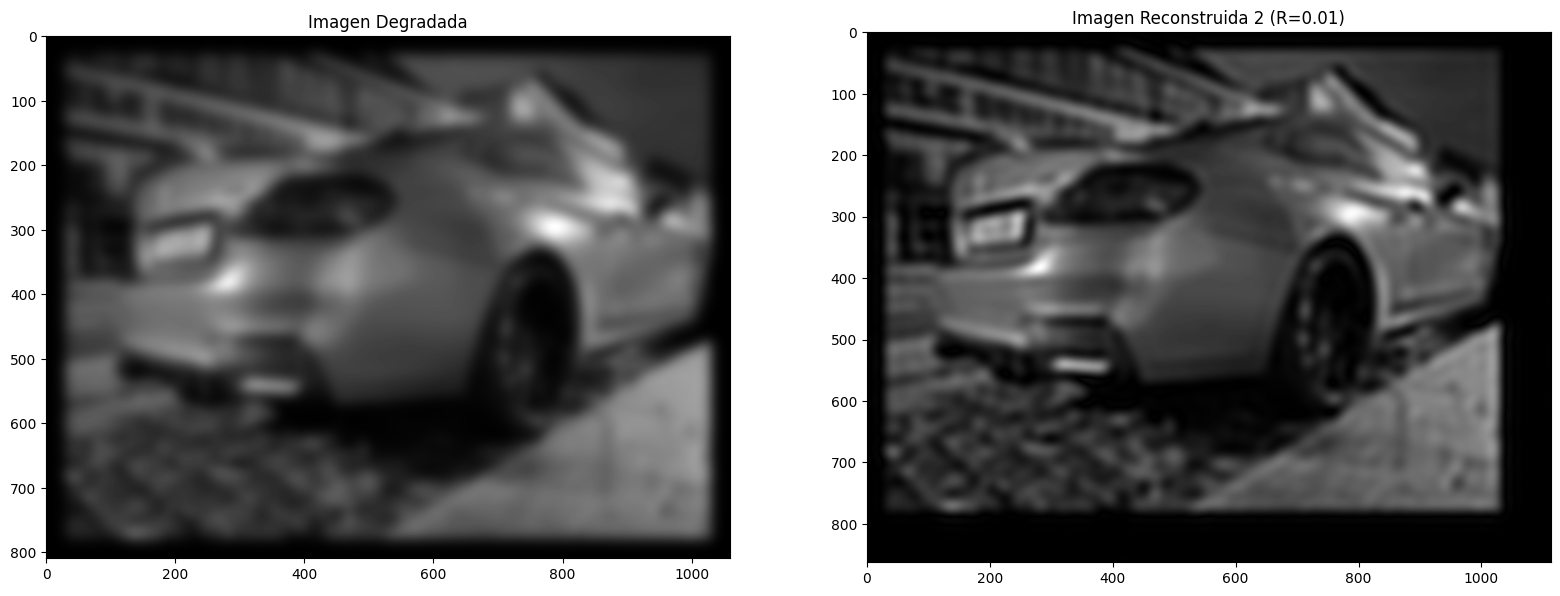

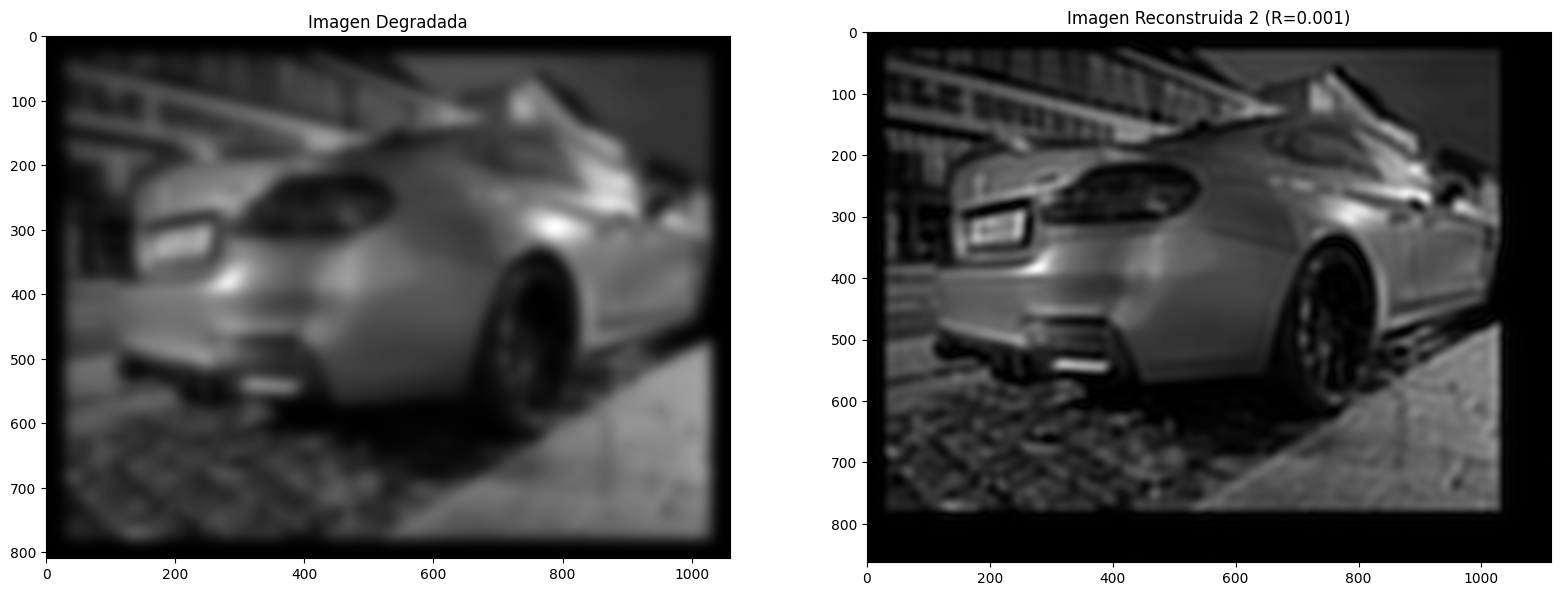

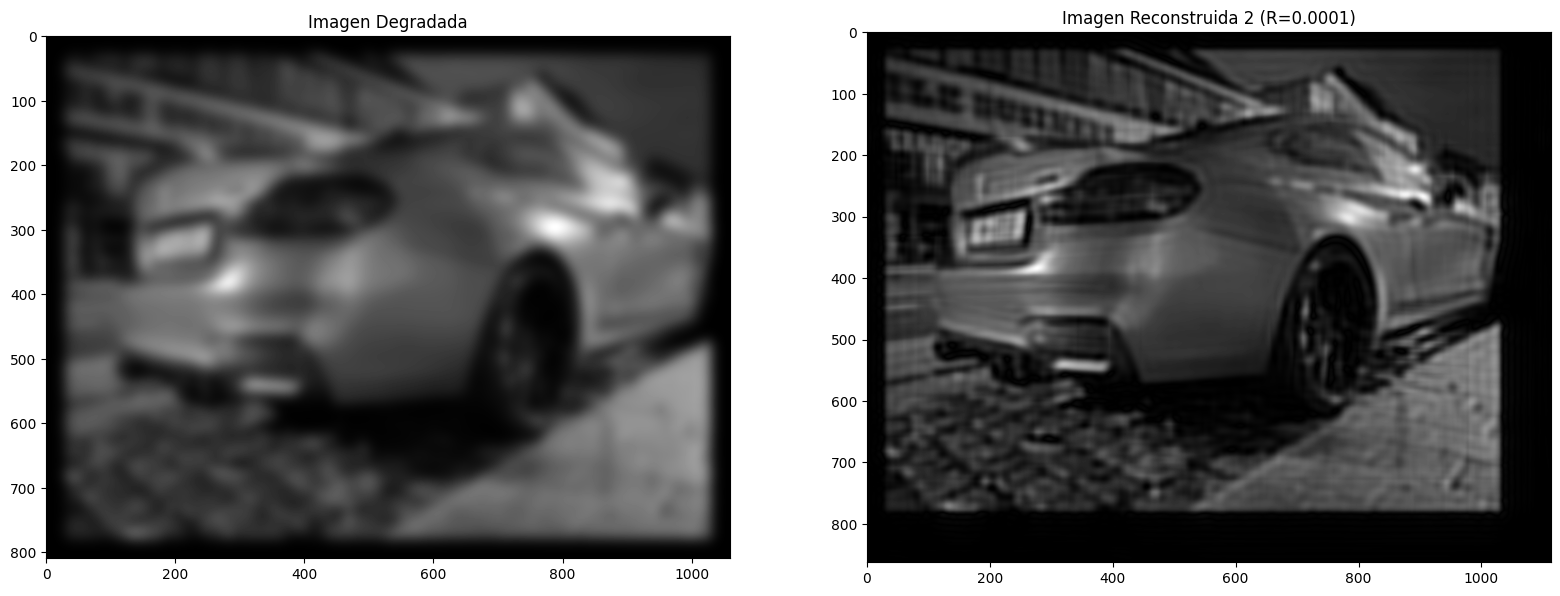

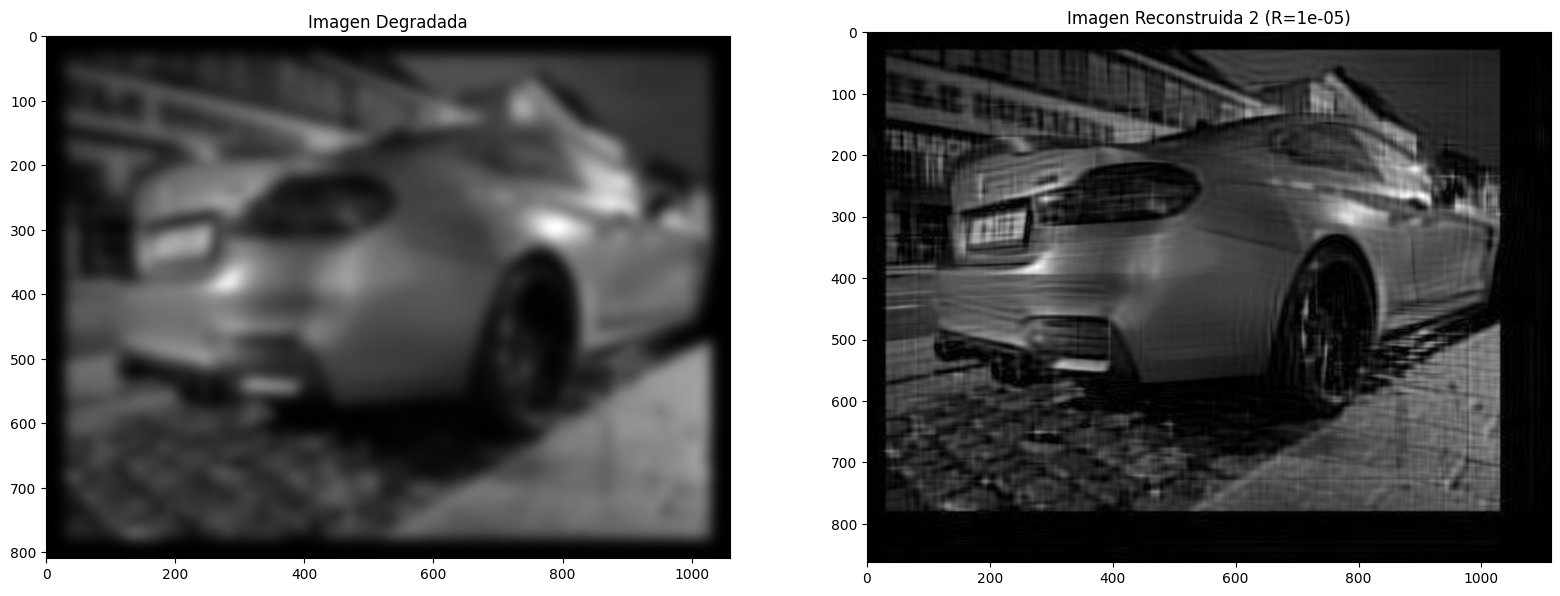

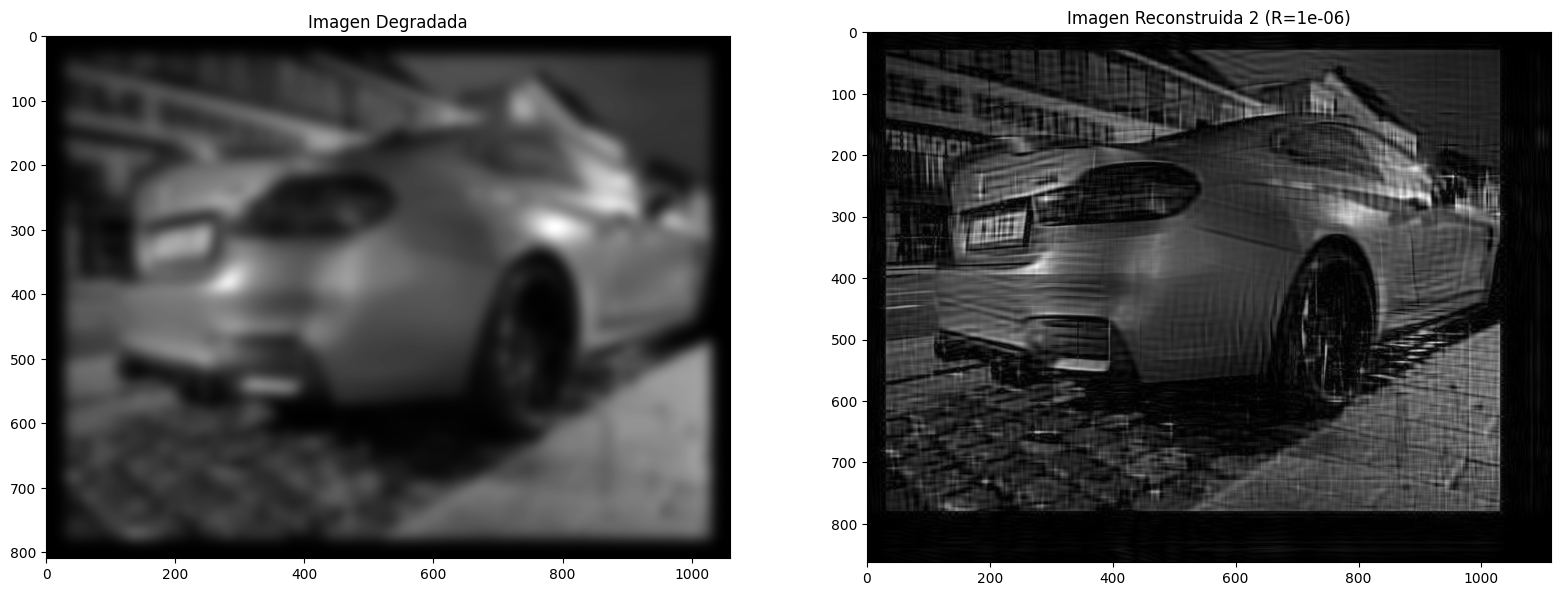

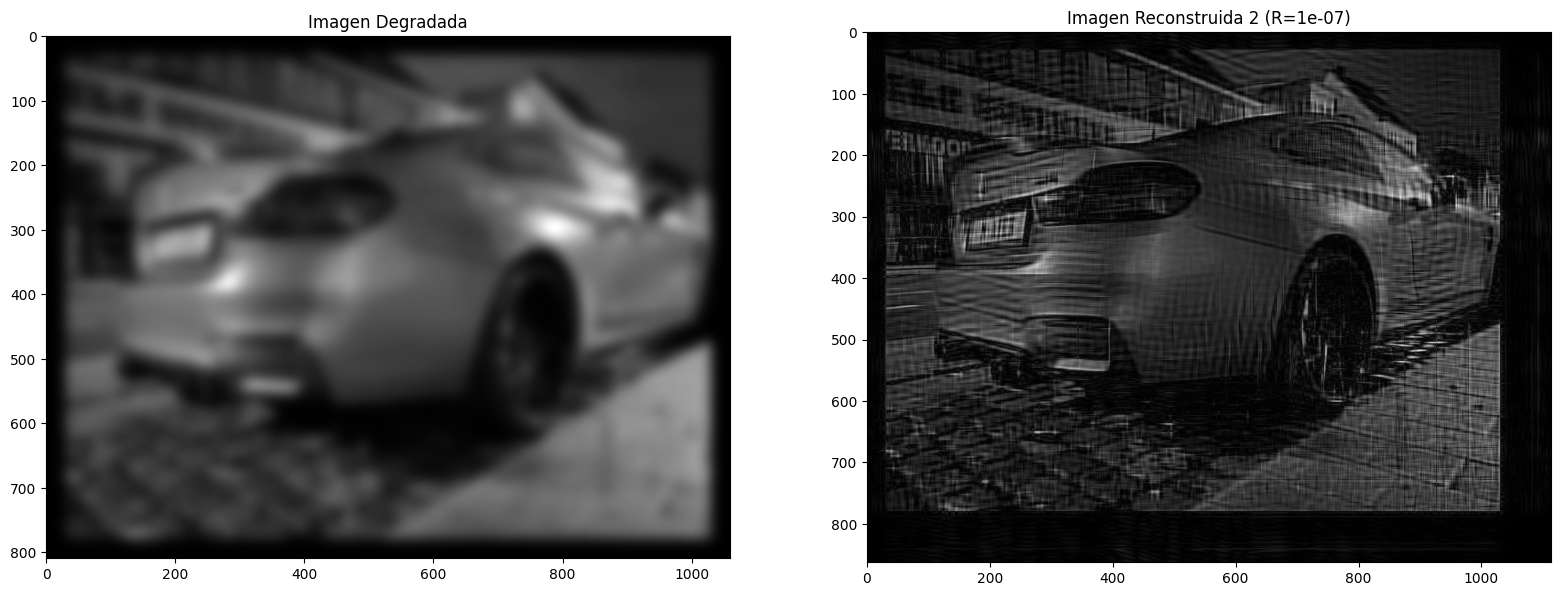

In [260]:
A, B = img_2.shape
C, D = gaussian_kernel.shape

P = A + C + 1
Q = B + D + 1

def native_wiener(img, kernel, A, B, P, Q, R):    

    padded_im = np.zeros((P, Q))
    padded_im[26:A+26, 26:B+26] = img

    padded_kernel = np.zeros((P, Q))
    padded_kernel[:C, :D] = kernel

    padded_img_fft = np.fft.fft2(padded_im)
    padded_kernel_fft = np.fft.fft2(padded_kernel)
    W = padded_kernel_fft.conjugate() / (np.abs(padded_kernel_fft) ** 2 + R)
    img = padded_img_fft * W
    reconstructed_im = np.abs(np.fft.ifft2(img))
    return reconstructed_im

for r in [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7]:

    # Aplica el filtro de Wiener
    img_restored_2 = native_wiener(
                        img_2, 
                        gaussian_kernel, 
                        A, 
                        B, 
                        P,
                        Q,
                        r)


    plt.figure(figsize=(30,30))

    plt.subplot(131)
    plt.title('Imagen Degradada')
    plt.imshow(img_2, cmap='gray')
    plt.subplot(132)
    plt.title(f'Imagen Reconstruida 2 (R={r})')
    plt.imshow(img_restored_2, cmap='gray')

##### Chequeo

importlib.reload(checker)

assert checker.check_license_plate_2(plate_2)
assert checker.check_img_2(img_restored_2)

**Ayuda:** si no logras descubrir las funciones de degradación, puedes usar ```checker.print_tip_1()``` y  ```checker.print_tip_2()``` para obtener tips.

## Chequeo final

La siguiente función revisará si los valores están correctos corriendo los mismos chequeos que antes.

Recuerda presionar _Validate_ arriba para que la plataforma corra todos los tests.

importlib.reload(checker)
assert checker.check_all(plate_1, img_restored_1, plate_2, img_restored_2)